## Export diagnostic videos

In [31]:
import glob
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import DictConfig, OmegaConf
import os
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import scipy
# from brainbox.behavior.dlc import get_smooth_pupil_diameter, get_pupil_diameter
import scipy
from eks.ensemble_kalman import filtering_pass, smooth_backward
import cv2
from matplotlib.gridspec import GridSpec
from diagnostics.video import get_frames_from_idxs, save_video
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from collections import defaultdict

ModuleNotFoundError: No module named 'diagnostics.video'

In [15]:
import openpyxl

def extract_numbers_from_xlsx(file_path, column_index):
    numbers = []
    workbook = openpyxl.load_workbook(file_path)

    for sheet_name in workbook.sheetnames:
        sheet = workbook[sheet_name]

        for row in sheet.iter_rows():
            cell = row[column_index]
            if cell.value is not None and isinstance(cell.value, (int, float)):
                numbers.append(cell.value)

    return numbers

#file_path = "/media/cat/cole/frames_2_mouse.xlsx"
#starts = extract_numbers_from_xlsx(file_path, 0)
#ends =  extract_numbers_from_xlsx(file_path, 1)
#video_ranges = zip(starts, ends)
#video_range_list = []
#for video_range in list(video_ranges):
#    video_range_list.append(np.asarray(video_range) - 1)
#video_range_list = np.asarray(video_range_list)

In [20]:
#(n_frames, n_animals, n_markers, 2)
base_path_markers = '/Users/clairehe/Downloads/wu-mouse/'

keys_all = ['0_x', '0_y', '1_x', '1_y', '2_x', '2_y']
key_pairs_all = [['0_x', '0_y'], ['1_x', '1_y'], ['2_x', '2_y']]

max_ensemble_vars = []
#for video_id, video_range in enumerate(video_range_list):
    #choose animal
animal_id = 0
markers_list = []
for i in range(5):
    marker_path = os.path.join(base_path_markers, f'predictions_{i}.npy')
    markers_animal_orig = np.load(marker_path)[:,animal_id]
    markers_animal_orig = markers_animal_orig.reshape(markers_animal_orig.shape[0], -1) 
    markers_animal = markers_animal_orig.copy() 
    for i in range(markers_animal.shape[1]):
        nan_indices = np.isnan(markers_animal[:,i])
        indices = np.arange(len(markers_animal[:,i]))
        # Interpolate over NaN values
        markers_animal[:,i][nan_indices] = np.interp(indices[nan_indices], indices[~nan_indices], markers_animal[:,i][~nan_indices])
    df_markers_animal = pd.DataFrame(markers_animal, columns=keys_all)
    markers_list.append(df_markers_animal)

ensemble_max_list = []
for key_pair in key_pairs_all:
    keys = key_pair

    ensemble_stacks = []
    ensemble_vars = []
    ensemble_preds = []
    keypoints_mean_dict = {}
    keypoints_var_dict = {}
    keypoints_stack_dict = defaultdict(dict)
    for key in keys:
        stack = np.zeros((len(markers_list), markers_list[0].shape[0]))
        for k in range(len(markers_list)):
            stack[k] = markers_list[k][key]
        stack = stack.T
        median = np.median(stack, 1)
        var = np.var(stack, 1) / len(markers_list)
        ensemble_preds.append(median)
        ensemble_vars.append(var)
        ensemble_stacks.append(stack)
        keypoints_mean_dict[key] = median
        keypoints_var_dict[key] = var
        for i, keypoints in enumerate(stack.T):
            keypoints_stack_dict[i][key] = stack.T[i]
    ensemble_preds = np.asarray(ensemble_preds).T
    ensemble_vars = np.asarray(ensemble_vars).T
    ensemble_max_list.append(np.max(ensemble_vars))
max_ensemble_vars.append(np.max(ensemble_max_list))
max_ensemble_vars = np.asarray(max_ensemble_vars)

In [21]:
np.savetxt('ensemble_var_order.txt', np.argsort(-max_ensemble_vars), fmt='%d')

In [22]:
np.argsort(-max_ensemble_vars)[:10]

array([0])

/Users/clairehe/Downloads/wu-mouse/raw_vid.mp4


0it [00:00, ?it/s]


NameError: name 'get_frames_from_idxs' is not defined

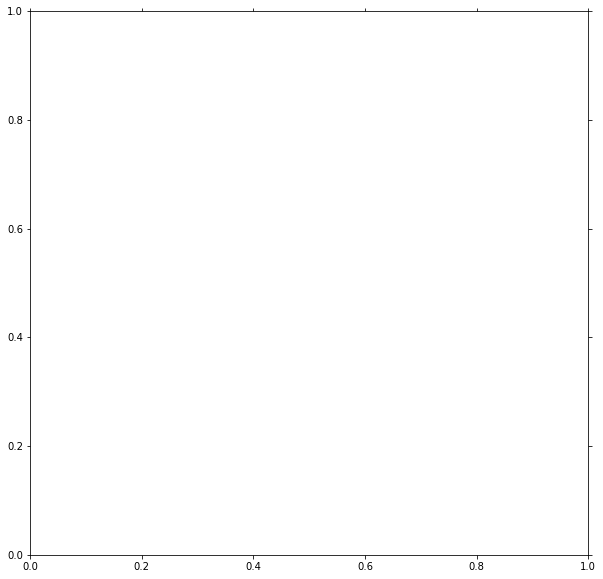

In [30]:
#(n_frames, n_animals, n_markers, 2)
base_path_markers = '/Users/clairehe/Downloads/wu-mouse/'

keys_all = ['0_x', '0_y', '1_x', '1_y', '2_x', '2_y']
key_pairs_all = [['0_x', '0_y'], ['1_x', '1_y'], ['2_x', '2_y']]


#choose animal
animal_id = 0
markers_list = []
for i in range(5):
    marker_path = os.path.join(base_path_markers, f'predictions_{i}.npy')
    markers_animal_orig = np.load(marker_path)[:,animal_id]
    markers_animal_orig = markers_animal_orig.reshape(markers_animal_orig.shape[0], -1) 
    markers_animal = markers_animal_orig.copy() 
    for i in range(markers_animal.shape[1]):
        nan_indices = np.isnan(markers_animal[:,i])
        indices = np.arange(len(markers_animal[:,i]))
        # Interpolate over NaN values
        markers_animal[:,i][nan_indices] = np.interp(indices[nan_indices], indices[~nan_indices], markers_animal[:,i][~nan_indices])
    df_markers_animal = pd.DataFrame(markers_animal, columns=keys_all)
    markers_list.append(df_markers_animal)

    from collections import defaultdict

y_m_smooth_dict = {}
marker_dict_list = []
ensemble_dict = {}
for key_pair in key_pairs_all:
    keys = key_pair

    ensemble_stacks = []
    ensemble_vars = []
    ensemble_preds = []
    keypoints_mean_dict = {}
    keypoints_var_dict = {}
    keypoints_stack_dict = defaultdict(dict)
    for key in keys:
        stack = np.zeros((len(markers_list), markers_list[0].shape[0]))
        for k in range(len(markers_list)):
            stack[k] = markers_list[k][key]
        stack = stack.T
        median = np.median(stack, 1)
        var = np.var(stack, 1) / len(markers_list)
        ensemble_preds.append(median)
        ensemble_vars.append(var)
        ensemble_stacks.append(stack)
        keypoints_mean_dict[key] = median
        keypoints_var_dict[key] = var
        for i, keypoints in enumerate(stack.T):
            keypoints_stack_dict[i][key] = stack.T[i]
    ensemble_preds = np.asarray(ensemble_preds).T
    ensemble_vars = np.asarray(ensemble_vars).T
    ensemble_stacks = np.asarray(ensemble_stacks).T

    #compute center of mass
    x_key = keys[0]
    y_key = keys[1]

    mean_x_obs = np.mean(keypoints_mean_dict[x_key])
    mean_y_obs = np.mean(keypoints_mean_dict[y_key])
    x_t_obs, y_t_obs = keypoints_mean_dict[x_key] - mean_x_obs, keypoints_mean_dict[y_key] - mean_y_obs #make the mean zero

    #latent variables (observed)
    z_t_obs = np.vstack((x_t_obs, y_t_obs)) #latent variables - true x and y

    ##### Set values for kalman filter #####
    m0 = np.asarray([0.0, 0.0]) # initial state: mean
    S0 =  np.asarray([[np.var(x_t_obs), 0.0], [0.0 , np.var(y_t_obs)]]) # diagonal: var

    smoothing_value = 20
    A = np.asarray([[1.0, 0], [0, 1.0]]) #state-transition matrix,
    Q = np.asarray([[smoothing_value, 0], [0, smoothing_value]]) #state covariance matrix -> smaller = more smoothing

    #['pupil_top_r_x', 'pupil_top_r_y', 'pupil_bottom_r_x', 'pupil_bottom_r_y', 'pupil_right_r_x', 'pupil_right_r_y', 'pupil_left_r_x', 'pupil_left_r_y'] 
    C = np.asarray([[1, 0], [0, 1]]) # Measurement function
    R = np.eye(2) # placeholder diagonal matrix for ensemble variance

    #left paw only
    scaled_ensemble_preds = ensemble_preds.copy()
    scaled_ensemble_stacks = ensemble_stacks.copy()

    #subtract means from the ensemble predictions
    for i in range(len(keys)):
        if i % 2 == 0:
            scaled_ensemble_preds[:, i] -= mean_x_obs
        else:
            scaled_ensemble_preds[:, i] -= mean_y_obs

    #subtract COM means from all the predictions
    for i in range(len(keys)):
        if i % 2 == 0:
            scaled_ensemble_stacks[:,:,i] -= mean_x_obs
        else:
            scaled_ensemble_stacks[:,:,i] -= mean_y_obs

    y = scaled_ensemble_preds

    #do filtering pass with time-varying ensemble variances
    mf, Vf, S = filtering_pass(y, m0, S0, C, R, A, Q, ensemble_vars)
    y_m_filt = np.dot(C, mf.T).T
    y_v_filt = np.swapaxes(np.dot(C, np.dot(Vf, C.T)), 0, 1)

    # Do the smoothing step
    ms, Vs, _ = smooth_backward(y, mf, Vf, S, A, Q, C)

    # Smoothed posterior over y
    y_m_smooth = np.dot(C, ms.T).T
    y_v_smooth = np.swapaxes(np.dot(C, np.dot(Vs, C.T)), 0, 1)

    #get a dict of keypoints for smoothed values
    for i, key in enumerate(keys):
        if 'x' in key:
            y_m_smooth_dict[key] = y_m_smooth.T[i] + mean_x_obs
        if 'y' in key:
            y_m_smooth_dict[key] = y_m_smooth.T[i] + mean_y_obs
        y_m_smooth_dict[key+'_var'] = y_v_smooth[:,i,i]

    #get a dict of keypoints for a single model
    for model_id in range(5):
        marker_dict = {}
        for i, key in enumerate(keys):
            marker_dict[key] = ensemble_stacks[model_id].T[i]
        marker_dict_list.append(marker_dict)

    #get a dict of keypoints for a ensemble model
    model_id = 0
    for i, key in enumerate(keys):
        ensemble_dict[key] = ensemble_preds.T[i]

base_path = '/Users/clairehe/Downloads/'
video_name = 'raw_vid'
print(os.path.join(base_path, f'wu-mouse/%s.mp4' % video_name))
cap = cv2.VideoCapture(os.path.join(base_path, f'wu-mouse/%s.mp4' % video_name))
n_frames = 1
start_frame = 0
frame_idxs = None

save_file = os.path.join(base_path, f'wu-mouse/s_{smoothing_value}', f'%s_{marker_id}_kalman_smoothed_{Q[1,1]}.mp4' % video_name)

tmp_dir = os.path.join(os.path.dirname(save_file), 'tmpZzZ')
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

frame_idxs = start_frame + np.arange(n_frames)
framerate = 20

def plot_video_markers(markers_dict, ax, frame_idx, n_frames, marker_shapes, colors, alphas, model_id=0):
    to_plot_dict = markers_dict
    for j, key_pair in enumerate(key_pairs_all):
        if key_pair[0] in to_plot_dict:
            ax.plot(to_plot_dict[key_pair[0]][frame_idx], to_plot_dict[key_pair[1]][frame_idx], marker_shapes[j], markeredgecolor='w', markersize=4, alpha=alphas[model_id], 
                    color=colors[model_id])
        if key_pair[0]+'_var' in to_plot_dict:
            ax.errorbar(x=to_plot_dict[key_pair[0]][frame_idx],
                        y=to_plot_dict[key_pair[1]][frame_idx],
                        xerr=to_plot_dict[key_pair[0]+'_var'][frame_idx],
                        yerr=to_plot_dict[key_pair[1]+'_var'][frame_idx],
                        color=colors[model_id],
                        alpha=alphas[model_id],
                        capsize=4)

marker_shapes = ['o', '^', 'D', 's']
model_colors = ['red', 'green']
colors = ['red']*len(marker_dict_list) + ['green']
single_alpha = .5
single_alpha_list = [single_alpha]*len(marker_dict_list)
alphas = single_alpha_list + [1.0]
model_labels = ['ensemble', f'kalman, E:{Q[1,1]}']
fr = 60
fig, ax = plt.subplots(1,1,figsize=(10, 10))
txt_fr_kwargs = {
    'fontsize': 14, 'color': [1, 1, 1], 'horizontalalignment': 'left',
    'verticalalignment': 'top', 'fontname': 'monospace',
    'bbox': dict(facecolor='k', alpha=0.25, edgecolor='none'),
    'transform': ax.transAxes
}
for idx, n in tqdm(enumerate(frame_idxs)):
    # important!! otherwise each frame will plot on top of the last
    ax.clear()

    frame = get_frames_from_idxs(cap, [n])
    # plot original frame
    ax.imshow(frame[0, 0], vmin=0, vmax=255, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    patches = []
    for model_id, markers_dict in enumerate(marker_dict_list + [y_m_smooth_dict]):
        plot_video_markers(markers_dict, ax, idx, n_frames, marker_shapes, colors, alphas, model_id=model_id)
    for i, model_label in enumerate(model_labels):
        patches.append(mpatches.Patch(color=model_colors[i], label=model_label))
    ax.legend(handles=patches)
    im = ax.text(0.02, 0.98, 'frame %i' % n, **txt_fr_kwargs)
    plt.savefig(os.path.join(tmp_dir, 'frame_%06i.jpeg' % idx))
save_video(save_file, tmp_dir, framerate, frame_pattern='frame_%06i.jpeg')

In [ ]:
np.max(ensemble_vars)

In [47]:
np.argmax(ensemble_vars[:,0])

5

In [48]:
ensemble_vars[5]

array([154.15656757,  95.83535661])

In [26]:
to_plot_dict

NameError: name 'to_plot_dict' is not defined

In [19]:
marker_id

0

In [18]:
np.eye(10)*4

array([[4., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 4., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 4., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 4., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 4., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 4., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 4., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 4., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 4., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 4.]])

In [ ]:
frame_idxs

In [7]:
n

72

In [ ]:
n_frames

In [44]:
# num_points = 2000
# fig, axes = plt.subplots(len(keys),1, figsize=(20,10*len(keys)))
# # obs_colors  = ['red', 'blue']
# # colors = ['black', 'green']
# for keypoint_id in range(len(keys)):
#     ax = axes[keypoint_id]
#     for k in range(len(markers_list)):
#         ax.scatter(np.arange(1, num_points + 1),
#                     ensemble_stacks[k][:,keypoint_id][:num_points],
#                     marker='x',
#                     color='red',
#                     zorder=3,
#                     alpha=.5)
#     ax.plot(np.arange(1, num_points + 1),
#                  ensemble_preds[:, keypoint_id][:num_points],
#             label='ensemble median')
#     ax.set_title(keys[keypoint_id], fontsize=16)
#     ax.set_xlabel(r'$t$', fontsize=16)
#     ax.legend()
# plt.show()

# Kalman Filtering + Smoothing

$z_t = (x_t, y_t)$ - right or left paw

$z_t = A z_{t-1} + e_t, e_t ~ N(0,E)$

$O_t = B z_t + n_t, n_t ~ N(0,D_t)$

## Set parameters

In [29]:
#compute center of mass
marker_id = 0
x_key = keys[marker_id*2]
y_key = keys[marker_id*2+1]

mean_x_obs = np.mean(keypoints_mean_dict[x_key])
mean_y_obs = np.mean(keypoints_mean_dict[y_key])
x_t_obs, y_t_obs = keypoints_mean_dict[x_key] - mean_x_obs, keypoints_mean_dict[y_key] - mean_y_obs #make the mean zero

#latent variables (observed)
z_t_obs = np.vstack((x_t_obs, y_t_obs)) #latent variables - true x and y

##### Set values for kalman filter #####
m0 = np.asarray([0.0, 0.0]) # initial state: mean
S0 =  np.asarray([[np.var(x_t_obs), 0.0], [0.0 , np.var(y_t_obs)]]) # diagonal: var

smoothing_value = .01
A = np.asarray([[1.0, 0], [0, 1.0]]) #state-transition matrix,
Q = np.asarray([[smoothing_value, 0], [0, smoothing_value]]) #state covariance matrix -> smaller = more smoothing

#['pupil_top_r_x', 'pupil_top_r_y', 'pupil_bottom_r_x', 'pupil_bottom_r_y', 'pupil_right_r_x', 'pupil_right_r_y', 'pupil_left_r_x', 'pupil_left_r_y'] 
C = np.asarray([[1, 0], [0, 1]]) # Measurement function
R = np.eye(2) # placeholder diagonal matrix for ensemble variance

#left paw only
scaled_ensemble_preds = ensemble_preds.copy()
scaled_ensemble_stacks = ensemble_stacks.copy()

#subtract means from the ensemble predictions
for i in range(len(keys)):
    if i % 2 == 0:
        scaled_ensemble_preds[:, i] -= mean_x_obs
    else:
        scaled_ensemble_preds[:, i] -= mean_y_obs

#subtract COM means from all the predictions
for i in range(len(keys)):
    if i % 2 == 0:
        scaled_ensemble_stacks[:,:,i] -= mean_x_obs
    else:
        scaled_ensemble_stacks[:,:,i] -= mean_y_obs

y = scaled_ensemble_preds

## Perform filtering

In [233]:
# #do filtering pass with time-varying ensemble variances
# mf, Vf, S = filtering_pass(y, m0, S0, C, R, A, Q, ensemble_vars)
# y_m_filt = np.dot(C, mf.T).T
# y_v_filt = np.swapaxes(np.dot(C, np.dot(Vf, C.T)), 0, 1)

In [45]:
# num_points = num_frames
# start_frame = 0
# fig, axes = plt.subplots(len(keys),1, figsize=(20,10*len(keys)))
# obs_colors  = ['red']
# colors = ['black']
# for keypoint_id in range(len(keys)):
#     ax = axes[keypoint_id]
#     for k in range(len(markers_list)):
#         if k == len(markers_list)-1:
#             label = 'observed'
#         else:
#             label = None
#         obs = markers_list[k][keys[keypoint_id]].to_numpy().copy()
#         ax.scatter(np.arange(start_frame, start_frame+num_points),
#                     obs[start_frame:start_frame+num_points],
#                     marker='x',
#                     color='red',
#                     label=label,
#                     zorder=3,
#                     alpha=.1)
#     plot_filtered = y_m_filt[:, keypoint_id].copy()
#     if keypoint_id % 2 == 0:
#         plot_filtered += mean_x_obs
#     else:
#         plot_filtered += mean_y_obs
#     ax.errorbar(x=np.arange(start_frame, start_frame+num_points),
#                  y=plot_filtered[start_frame:start_frame+num_points],
#                  yerr=y_v_filt[:, keypoint_id, keypoint_id][start_frame:start_frame+num_points] ** 0.5,
#                  color='black',
#                  zorder=2,
#                  fmt="none",
#                  label=keys[keypoint_id] + r"$, m_t^t \pm \sqrt{V_t^t}$",
#                  capsize=4)
#     ax.plot(np.arange(start_frame, start_frame+num_points),
#                  plot_filtered[start_frame:start_frame+num_points],
#                  color='black')
    
#     ax.scatter(np.arange(start_frame, start_frame+num_points),
#                     ensemble_preds[start_frame:start_frame+num_points:,keypoint_id],
#                     marker='x',
#                     color='blue',
#                     label='ensemble median',
#                     zorder=3,
#                     alpha=.1)
#     ax.set_title(f'E: {Q}', fontsize=16)
#     ax.set_xlabel(r'$t$', fontsize=16)
#     ax.set_ylabel("pixels", fontsize=16)
#     ax.legend()
# plt.show()

## Perform smoothing

In [235]:
# Do the smoothing step
ms, Vs, _ = smooth_backward(y, mf, Vf, S, A, Q, C)

# Smoothed posterior over y
y_m_smooth = np.dot(C, ms.T).T
y_v_smooth = np.swapaxes(np.dot(C, np.dot(Vs, C.T)), 0, 1)

In [46]:
# num_points = num_frames
# start_frame = 0
# fig, axes = plt.subplots(len(keys),1, figsize=(20,10*len(keys)))
# obs_colors  = ['red']
# colors = ['black']
# for keypoint_id in range(len(keys)):
#     ax = axes[keypoint_id]
#     for k in range(len(markers_list)):
#         if k == len(markers_list)-1:
#             label = 'observed'
#         else:
#             label = None
#         obs = markers_list[k][keys[keypoint_id]].to_numpy().copy()
#         ax.scatter(np.arange(start_frame, start_frame+num_points),
#                     obs[start_frame:start_frame+num_points],
#                     marker='x',
#                     color='red',
#                     label=label,
#                     zorder=3,
#                     alpha=.1)
#     plot_smoothed = y_m_smooth[:, keypoint_id].copy()
#     if keypoint_id % 2 == 0:
#         plot_smoothed += mean_x_obs
#     else:
#         plot_smoothed += mean_y_obs
#     ax.errorbar(x=np.arange(start_frame, start_frame+num_points),
#                  y=plot_smoothed[start_frame:start_frame+num_points],
#                  yerr=y_v_smooth[:, keypoint_id, keypoint_id][start_frame:start_frame+num_points] ** 0.5,
#                  color='black',
#                  zorder=2,
#                  fmt="none",
#                  label=keys[keypoint_id] + r"$, m_t^t \pm \sqrt{V_t^t}$",
#                  capsize=4)
#     ax.plot(np.arange(start_frame, start_frame+num_points),
#                  plot_smoothed[start_frame:start_frame+num_points],
#                  color='black')
    
#     ax.scatter(np.arange(start_frame, start_frame+num_points),
#                     ensemble_preds[start_frame:start_frame+num_points:,keypoint_id],
#                     marker='x',
#                     color='blue',
#                     label='ensemble median',
#                     zorder=3,
#                     alpha=.5)
#     ax.set_title(f'E: {Q}', fontsize=16)
#     ax.set_xlabel(r'$t$', fontsize=16)
#     ax.set_ylabel("pixels", fontsize=16)
#     ax.legend()

#         # ax.show()
# plt.savefig(f'/media/cat/cole/wu-mouse/marker{marker_id}_kalman_smoothed_traces_{Q[1,1]}.png')
# plt.show()

## Make videos

In [14]:
model_id

NameError: name 'model_id' is not defined

In [238]:
#get a dict of keypoints for smoothed values
y_m_smooth_dict = {}
for i, key in enumerate(keys):
    if 'x' in key:
        y_m_smooth_dict[key] = y_m_smooth.T[i] + mean_x_obs
    if 'y' in key:
        y_m_smooth_dict[key] = y_m_smooth.T[i] + mean_y_obs
    y_m_smooth_dict[key+'_var'] = y_v_smooth[:,i,i]
    
#get a dict of keypoints for a single model
marker_dict_list = []
for model_id in range(5):
    marker_dict = {}
    for i, key in enumerate(keys):
        marker_dict[key] = ensemble_stacks[model_id].T[i]
    marker_dict_list.append(marker_dict)
    
#get a dict of keypoints for a ensemble model
model_id = 0
ensemble_dict = {}
for i, key in enumerate(keys):
    ensemble_dict[key] = ensemble_preds.T[i]

In [239]:
y_m_smooth_dict

{'0_x': array([1121.47176873, 1120.74631391, 1116.00666408, 1109.44721178,
        1091.91412706, 1074.24409576, 1056.57481925, 1039.88013799,
        1024.41387634, 1012.99842692, 1001.81809454,  991.40896002,
         981.12815804,  971.07204745,  961.05608691,  950.89996909,
         940.92357384,  931.08942983,  920.59025278,  909.28707931,
         894.79215538,  878.90647336,  859.61163409,  838.6502338 ,
         816.19446003,  792.55036162,  768.60945185,  744.79936882,
         721.84421983,  699.88925627,  678.92078442,  662.00557542,
         646.46691346,  632.48070513,  619.59433986,  607.59821907,
         597.04986458,  586.922336  ,  575.97248498,  564.60343079,
         552.57550433,  538.9018386 ,  524.37497353,  509.03669131,
         485.29136199,  456.65395701,  427.97072633,  392.54507679,
         357.7719982 ,  323.79684794,  290.17929122,  257.62826496,
         242.36447798,  227.70330478,  213.73412235,  201.24601451,
         189.94615942,  179.86078849,  17

In [240]:
# save_paw = paw
# if camera == 'right':
#     if paw == 'left':
#         save_paw = 'right'
#         y_m_smooth_dict['paw_r_x'] = y_m_smooth_dict.pop('paw_l_x')
#         y_m_smooth_dict['paw_r_y'] = y_m_smooth_dict.pop('paw_l_y')
#         y_m_smooth_dict['paw_r_x_var'] = y_m_smooth_dict.pop('paw_l_x_var')
#         y_m_smooth_dict['paw_r_y_var'] = y_m_smooth_dict.pop('paw_l_y_var')
#     else:
#         save_paw = 'left'
#         y_m_smooth_dict['paw_l_x'] = y_m_smooth_dict.pop('paw_r_x')
#         y_m_smooth_dict['paw_l_y'] = y_m_smooth_dict.pop('paw_r_y')
#         y_m_smooth_dict['paw_l_x_var'] = y_m_smooth_dict.pop('paw_r_x_var')
#         y_m_smooth_dict['paw_l_y_var'] = y_m_smooth_dict.pop('paw_r_y_var')
# outfile = f'/media/cat/cole/{video_name}_{camera}_camera_{save_paw}_paw_smoothed_dict.npz'
# print(outfile)
# np.savez(outfile, **y_m_smooth_dict)

# # npzfile = np.load(outfile)
# # print('npzfile.files: {}'.format(npzfile.files))
# # print('npzfile["paw_r_x"]: {}'.format(npzfile["paw_r_x"]))

In [241]:
video_name

'raw_vid'

In [13]:
import cv2
from matplotlib.gridspec import GridSpec
from diagnostics.video import get_frames_from_idxs, save_video
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

base_path = '/media/cat/cole/'
video_name = 'raw_vid'
print(os.path.join(base_path, f'wu-mouse/%s.mp4' % video_name))
cap = cv2.VideoCapture(os.path.join(base_path, f'wu-mouse/%s.mp4' % video_name))
n_frames = num_frames
start_frame = 0
frame_idxs = None

save_file = os.path.join(base_path, 'wu-mouse', f'%s._{marker_id}_kalman_smoothed_{Q[1,1]}.mp4' % video_name)

tmp_dir = os.path.join(os.path.dirname(save_file), 'tmpZzZ')
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

frame_idxs = start_frame + np.arange(n_frames)
framerate = 20

def plot_video_markers(markers_dict, ax, n_frames, marker_shapes, colors, alphas, model_id=0):
    to_plot_dict = defaultdict(list)
    for i, key in enumerate(markers_dict.keys()):
        markers = markers_dict[key].copy()
        if 'var' in key:
            to_plot_dict['var'].append(markers)
        else:
            to_plot_dict['v'].append(markers)
    for j, key in enumerate(to_plot_dict.keys()):
        if 'var' not in key:
            ax.plot(to_plot_dict[key][0][n], to_plot_dict[key][1][n], marker_shapes[j], markeredgecolor='w', markersize=4, alpha=alphas[model_id], 
                    color=colors[model_id])
        else:
            ax.errorbar(x=to_plot_dict[key[0]][0][n],
                        y=to_plot_dict[key[0]][1][n],
                        xerr=to_plot_dict[key][0][n],
                        yerr=to_plot_dict[key][1][n],
                        color=colors[model_id],
                        alpha=alphas[model_id],
                        capsize=4)

marker_shapes = ['o', '^', 'D', 's']
model_colors = ['red', 'green']
colors = ['red']*len(marker_dict_list) + ['green']
single_alpha = .5
single_alpha_list = [single_alpha]*len(marker_dict_list)
alphas = single_alpha_list + [1.0]
model_labels = ['ensemble', f'kalman, E:{Q[1,1]}']
fr = 60
fig, ax = plt.subplots(1,1,figsize=(10, 10))
txt_fr_kwargs = {
    'fontsize': 14, 'color': [1, 1, 1], 'horizontalalignment': 'left',
    'verticalalignment': 'top', 'fontname': 'monospace',
    'bbox': dict(facecolor='k', alpha=0.25, edgecolor='none'),
    'transform': ax.transAxes
}
for idx, n in tqdm(enumerate(frame_idxs)):
    # important!! otherwise each frame will plot on top of the last
    ax.clear()
    
    frame = get_frames_from_idxs(cap, [n])
    # plot original frame
    ax.imshow(frame[0, 0], vmin=0, vmax=255, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    
    patches = []
    for model_id, markers_dict in enumerate(marker_dict_list + [y_m_smooth_dict]):
        plot_video_markers(markers_dict, ax, n_frames, marker_shapes, colors, alphas, model_id=model_id)
    for i, model_label in enumerate(model_labels):
        patches.append(mpatches.Patch(color=model_colors[i], label=model_label))
    ax.legend(handles=patches)
    im = ax.text(0.02, 0.98, 'frame %i' % n, **txt_fr_kwargs)
    plt.savefig(os.path.join(tmp_dir, 'frame_%06i.jpeg' % idx))
save_video(save_file, tmp_dir, framerate, frame_pattern='frame_%06i.jpeg')

ModuleNotFoundError: No module named 'diagnostics.video'